# Product Catalog Categorization
---
## Example Solution

This challenge is based on a classification problem for product cataloging, given its numerical, descriptive, textual and image attributes, in one of the 20 possible classes. <br>
There are 95417 examples for training and 23855 for testing. <br>
Distributed among the following classes:

**Class | Examples**<br>
**Camiseta**                  37061 <br>
**Tênis**                     12874 <br>
**Bermuda**                    7179 <br>
**Boné**                       6229 <br>
**Moletom**                    4885 <br>
**Blusa**                      3602 <br>
**Calça**                      3238 <br>
**Polo**                       2569 <br>
**Mochila**                    2506 <br>
**Óculos**                     2284 <br>
**Shorts**                     1790 <br>
**Acessório de Vestuário**     1749 <br>
**Camisa**                     1674 <br>
**Casacos e Jaquetas**         1540 <br>
**Meia**                       1342 <br>
**Roupa de Banho**             1106 <br>
**Bagagem Pequena**             988 <br>
**Bota**                        974 <br>
**Vestido**                     936 <br>
**Chinelo**                     891 <br>

Each example has 15 attributes and their label, defined as follows:<br>
**product_id**: unique product identifier:<br>
**product_name**: product name:<br>
**brand**: product brand:<br>
**product_description**: textual description of the product:<br>
**gender**: gender to which the product fits:<br>
**color**: product color:<br>
**price**: original price of the product:<br>
**special_price**: current price of the product:<br>
**division**: division to which the product is linked:<br>
**box_weight**: weight of the product box:<br>
**box_length**: length of the product box:<br>
**box_height**: height of the product box:<br>
**box_width**: width of the product box:<br>
**product_large_image**: link to the corresponding product image:<br>
**position_in_stock**: sector to which the product is allocated:<br>
**category**: category to which the product is linked (attribute to be provided):<br>

## 1 - Importation of Libraries and Datasets Reading

In [1]:
import catboost as cb
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import re
import string

from matplotlib.colors import LinearSegmentedColormap
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'grey'])
plt.style.use('seaborn-dark')

In [2]:
train = pd.read_csv('dafiti_catalog_challenge_train.csv')
test = pd.read_csv('dafiti_catalog_challenge_test.csv')
train.head()

,Unnamed: 0,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
0,12477,6582956371EA2F8187DDD37994C29E48,Produto Sebulba Position 2,Sebulba,Projetado Para Atender Às Necessidades Dos Atl...,Masculino,Azul,299.99,219.99,Sports Shoes,6.4,149.8,90.4,239.0,http://img.kstatic.com.br/p/0-428821-1-zoom.jpg,Setor P,Tênis
1,163318,EEB11409386655F4C7FC14CCF818E7F8,Produto <BRAND_000209> Shoot And Destroy,<BRAND_000209>,<Strong>Produto <BRAND_000209> Shoot And Destr...,Masculino,Preto,79.99,54.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-476802-1-zoom.jpg,Setor A,Camiseta
2,163272,C23C624AADA631D0CDFF64EB6A1F9F47,Produto Regata Boba Fett Soft,Boba Fett,"<H3>Com A Produto Regata Boba Fett Soft\, Você...",Masculino,Branco,59.99,44.99,Sports Apparel,2.3,NaN,216.7,16.1,http://img.kstatic.com.br/p/0-00132-1-zoom.jpg,Setor H,Camiseta
3,1087,7F86182F869D2FFED287B22494004311,Produto Owen Needs,Owen,"<Strong>Produto Owen Needs</Strong>\, Modelage...",Masculino,Branco,74.99,69.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-197762-1-zoom.jpg,Setor P,Camiseta
4,151045,34C5C06A0C32C5F295C2C3AD5AA69273,Produto Ackbar Estampada 4083,Ackbar,<Strong>Produto Ackbar Estampada 4083</Strong>...,Masculino,Branco,49.99,39.99,Sports Apparel,2.5,246.4,194.4,23.5,http://img.kstatic.com.br/p/0-172711-1-zoom.jpg,Setor A,Camiseta


In [3]:
X = train
y = train['category']
train, valid, _, _ = train_test_split(
    X, 
    y, 
    test_size=0.3, 
    random_state=42,
    stratify=y,
)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66791 entries, 71088 to 34870
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           66791 non-null  int64  
 1   product_id           66791 non-null  object 
 2   product_name         66791 non-null  object 
 3   brand                66791 non-null  object 
 4   product_description  66784 non-null  object 
 5   gender               66791 non-null  object 
 6   color                66684 non-null  object 
 7   price                66791 non-null  float64
 8   special_price        66791 non-null  float64
 9   division             66791 non-null  object 
 10  box_weight           60148 non-null  float64
 11  box_length           56685 non-null  float64
 12  box_height           61473 non-null  float64
 13  box_width            58762 non-null  float64
 14  product_large_image  66791 non-null  object 
 15  position_in_stock    66791 non-n

## 2 - Preprocess and Data Visualization

### 2.1 - Features Elimination

In [5]:
columns_to_drop = ['Unnamed: 0', 'product_id', 'product_large_image', 'category_hash']
train = train.drop(columns=columns_to_drop[0:-1])
valid = valid.drop(columns=columns_to_drop[0:-1])
test = test.drop(columns=columns_to_drop)
train.head()

,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,position_in_stock,category
71088,Produto Grievous Básica,Grievous,"Casual\, A <B>Produto Grievous Básica</B> Vai ...",Masculino,Azul Marinho,54.99,49.99,Sports Apparel,2.8,194.4,246.4,23.5,Setor L,Camiseta
3589,Produto Luke Skywalker Eclipsed Rasta,Luke Skywalker,<H3>Visual Alternativo Para Os Pés Com O Produ...,Masculino,Preto,79.99,59.99,Sports Shoes,3.7,97.8,209.2,NaN,Setor G,Chinelo
25843,Produto C-3PO Major,C-3PO,"<Strong>Produto C-3PO Major</Strong>\, Modelag...",Masculino,Preto,179.99,144.99,Sports Apparel,3.3,NaN,246.4,30.9,Setor J,Bermuda
60066,Produto R5-D4 Gotye,R5-D4,<H3>Garanta Um Visual Estiloso Com O Produto R...,Masculino,Verde,194.99,119.99,Sports Apparel,4.5,246.4,194.4,23.5,Setor B,Moletom
69732,Produto Jeans R5-D4 Aloha,R5-D4,<H3>A Produto Jeans R5-D4 Aloha É A Tua Cara.<...,Masculino,Azul,214.99,139.99,Sports Apparel,5.1,157.2,45.8,90.4,Setor B,Calça


### 2.2 - Missing Values

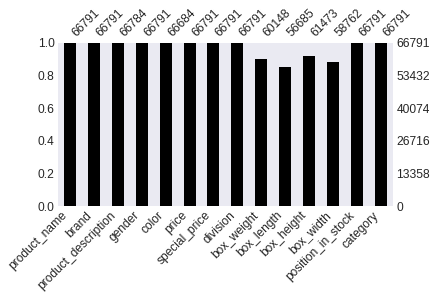

In [6]:
msno.bar(train, figsize=(6, 3), color='black', fontsize=12) 

In [7]:
values = {
    'color': train['color'].mode()[0],
    'box_weight': train['box_weight'].median(),
    'box_length': train['box_length'].median(),
    'box_height': train['box_height'].median(),
    'box_width': train['box_width'].median()
}
train = train.fillna(value=values)
valid = valid.fillna(value=values)
test = test.fillna(value=values)

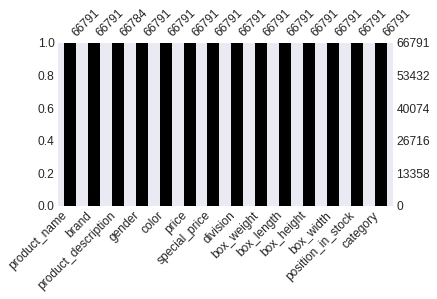

In [8]:
msno.bar(train, figsize=(6, 3), color='black', fontsize=12) 

### 2.3 - Data Visualization

In [9]:
train.describe(include='all')

,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,position_in_stock,category
count,66791,66791,66784,66791,66791,6.679100e+04,6.679100e+04,66791,66791.000000,66791.000000,66791.000000,66791.000000,66791,66791
unique,37432,382,47602,5,245,NaN,NaN,4,NaN,NaN,NaN,NaN,17,20
top,Produto Darth Vader Icon,Luke Skywalker,"<B>Qualidade E Tradição Entre Ciclistas\, A <B...",Masculino,Preto,NaN,NaN,Sports Apparel,NaN,NaN,NaN,NaN,Setor P,Camiseta
freq,113,3560,36,50986,16608,NaN,NaN,42177,NaN,NaN,NaN,NaN,4021,25942
mean,NaN,NaN,NaN,NaN,NaN,7.138623e+04,5.388890e+04,NaN,3.455933,140.816538,135.912539,163.741621,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,4.008723e+05,3.060813e+05,NaN,2.552615,84.327629,86.887369,74.765259,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,-1.000000e+02,-1.000000e+02,NaN,1.200000,1.200000,1.200000,1.200000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,7.499000e+01,5.499000e+01,NaN,2.300000,45.800000,53.200000,127.500000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,1.099900e+02,8.499000e+01,NaN,2.800000,149.800000,134.900000,187.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.999900e+02,1.499900e+02,NaN,3.300000,194.400000,216.700000,216.700000,NaN,NaN


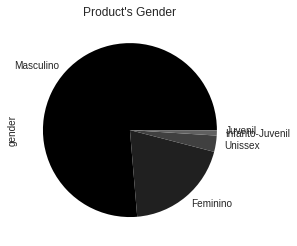

In [10]:
train['gender'].value_counts().plot(kind='pie', cmap=cmap, title='Product\'s Gender')

Luke Skywalker    3560
C-3PO             2958
R2-D2             2521
Darth Vader       2430
Leia              2103
                  ... 
<BRAND_000294>       1
<BRAND_000268>       1
<BRAND_000293>       1
<BRAND_000278>       1
<BRAND_000303>       1
Name: brand, Length: 382, dtype: int64


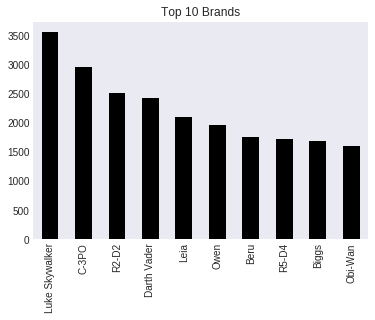

In [11]:
print(train['brand'].value_counts())
train['brand'].value_counts()[:10].plot(kind='bar', color='black', title='Top 10 Brands')

Preto          16608
Branco          9525
Azul            7015
Cinza           5248
Vermelho        3241
               ...  
Canela             1
Carmesim           1
Azul Cadete        1
Platina            1
Azul Alice         1
Name: color, Length: 245, dtype: int64


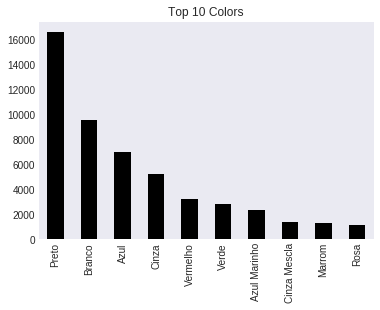

In [12]:
print(train['color'].value_counts())
train['color'].value_counts()[:10].plot(kind='bar', color='black', title='Top 10 Colors')

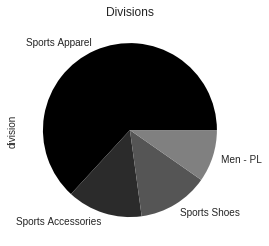

In [13]:
train['division'].value_counts()[:10].plot(kind='pie', cmap=cmap, title='Divisions')

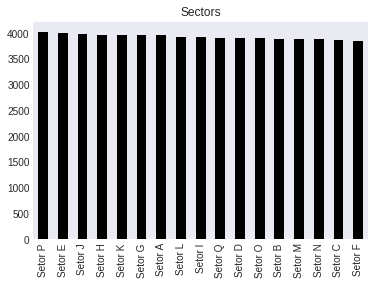

In [14]:
train['position_in_stock'].value_counts().plot(kind='bar', color='black', title='Sectors')

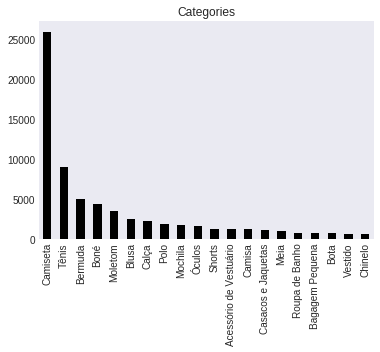

In [15]:
train['category'].value_counts().plot(kind='bar', color='black', title='Categories')

In [16]:
for i in range(10):
    print("Class =", train.iloc[i]['category'] , "->", train.iloc[i]['product_name'])
    print('---------------------------')

Class = Camiseta -> Produto Grievous Básica
---------------------------
Class = Chinelo -> Produto Luke Skywalker Eclipsed Rasta
---------------------------
Class = Bermuda -> Produto C-3PO Major
---------------------------
Class = Moletom -> Produto R5-D4 Gotye
---------------------------
Class = Calça -> Produto Jeans R5-D4 Aloha
---------------------------
Class = Boné -> Produto Fisto
---------------------------
Class = Roupa de Banho -> Sunga Luke Skywalker Dane
---------------------------
Class = Tênis -> Produto Ki-Adi-Mundi Flux
---------------------------
Class = Camiseta -> Produto <BRAND_000013> Bill
---------------------------
Class = Mochila -> Produto C-3PO Ozone Block B/P
---------------------------


In [17]:
for i in range(5):
    print("Class =", train.iloc[i]['category'] , "\n", train.iloc[i]['product_description'])
    print('---------------------------')

Class = Camiseta 
 Casual\, A <B>Produto Grievous Básica</B> Vai Deixar Suas Atividades Diárias Cheias De Conforto. Confeccionada Em Algodão\, A Peça É Leve\, Macia E Com Contato Suave À Pele. Sua Modelagem Tradicional Ajusta-Se Perfeitamente Ao Seu Corpo E Fornece Liberdade De Movimentos. Possui Bordado Frontal Com A Assinatura Da Marca E Gola Careca. Tenha Um Estilo Esportivo No Seu Dia A Dia Ou Em Passeios Casuais Com A <B>Produto Grievous Básica</B>.<Br><Br>
---------------------------
Class = Chinelo 
 <H3>Visual Alternativo Para Os Pés Com O Produto Luke Skywalker Eclipsed Rasta.</H3>Produzido Em Material Leve\, Resistente E Durável\, O <Strong>Produto Luke Skywalker Eclipsed Rasta</Strong> Possui Tiras Que Permitem Perfeito Ajuste Aos Pés\, Garantindo Maior Bem-Estar E Pisadas Confortáveis E Macias. Seu Solado Vem Emborrachado Para Melhor Aderência Ao Solo\, Dando Estabilidade E Segurança Nas Passadas. Ideal Para Te Acompanhar Nos Dias Quentes Para Ir À Piscina Ou À Praia\, O <S

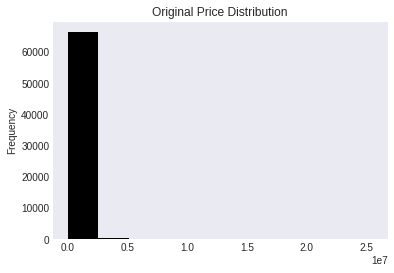

In [18]:
train['price'].plot(kind='hist', bins=10, color='black', title='Original Price Distribution')

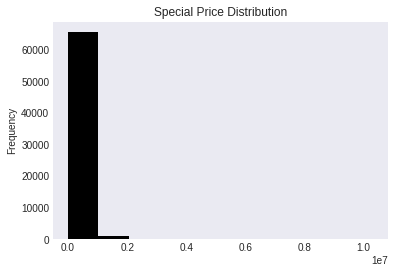

In [19]:
train['special_price'].plot(kind='hist', bins=10, color='black', title='Special Price Distribution')

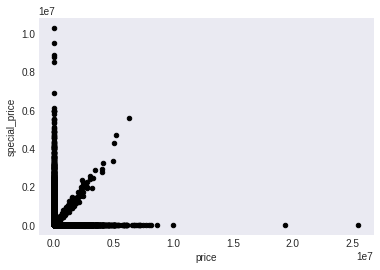

In [20]:
train.plot(x='price', y='special_price', kind='scatter', color='black')

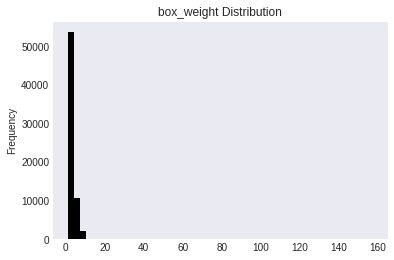

In [21]:
train['box_weight'].plot(kind='hist', bins=50, color='black', title='box_weight Distribution')

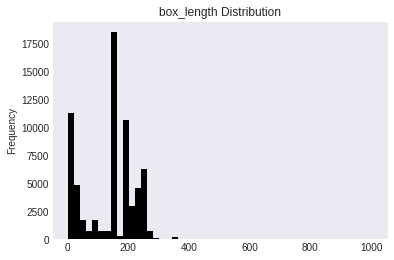

In [22]:
train['box_length'].plot(kind='hist', bins=50, color='black', title='box_length Distribution')

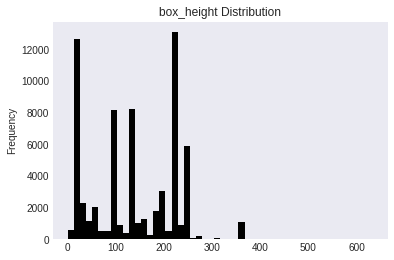

In [23]:
train['box_height'].plot(kind='hist', bins=50, color='black', title='box_height Distribution')

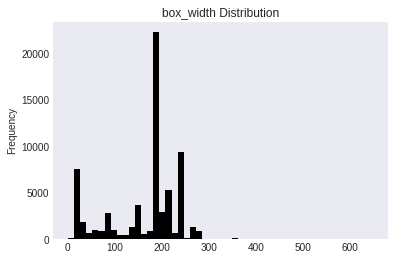

In [24]:
train['box_width'].plot(kind='hist', bins=50, color='black', title='box_width Distribution')

### 2.4 - Outlier's Treatment

In [25]:
q9 = train.quantile(0.9)
q1 = train.quantile(0.1)

for df in [train, valid, test]:
    df.loc[df['price'] > q9['price'], 'price'] = q9['price']
    df.loc[df['special_price'] > q9['special_price'], 'special_price'] = q9['special_price']

    df.loc[df['price'] < q1['price'], 'price'] = q1['price']
    df.loc[df['special_price'] < q1['special_price'], 'special_price'] = q1['special_price']

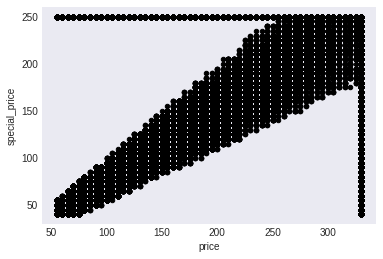

In [26]:
train.plot(x='price', y='special_price', kind='scatter', color='black')

## 3 - Experimentation

### 3.1 - Model 1: Only Categorical and Numeric Features

In [27]:
columns_to_ignore = ['product_name', 'product_description', 'category']
X_train, y_train = train.drop(columns=columns_to_ignore), train['category']
X_valid, y_valid = valid.drop(columns=columns_to_ignore), valid['category']

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(66791, 11)
(66791,)
(28626, 11)
(28626,)


In [29]:
cat_features = np.where(X_train.dtypes=='object')[0]
print(X_train.columns[cat_features])

Index(['brand', 'gender', 'color', 'division', 'position_in_stock'], dtype='object')


In [30]:
model = cb.CatBoostClassifier(
    eval_metric='Accuracy', 
    random_seed=42, 
    iterations=100,
    depth=7,
    learning_rate=0.1,
)

In [31]:
model.fit(
    X_train, 
    y_train, 
    cat_features=cat_features, 
    eval_set=(X_valid, y_valid), 
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [32]:
y_pred = model.predict(X_valid)

In [33]:
categories = y_valid.value_counts().index
print(classification_report(y_valid, y_pred.flatten(), target_names=categories))

                        precision    recall  f1-score   support

              Camiseta       0.83      0.72      0.77       525
                 Tênis       0.68      0.50      0.58       296
               Bermuda       0.86      0.86      0.86      2154
                  Boné       0.62      0.71      0.66      1081
               Moletom       0.94      0.96      0.95      1869
                 Blusa       0.90      0.75      0.82       292
                 Calça       0.80      0.78      0.79       971
                  Polo       0.75      0.46      0.57       502
               Mochila       0.88      0.97      0.92     11119
                Óculos       0.76      0.44      0.55       462
                Shorts       0.98      0.81      0.89       267
Acessório de Vestuário       0.92      0.79      0.85       403
                Camisa       0.85      0.92      0.89       752
    Casacos e Jaquetas       0.81      0.88      0.84      1465
                  Meia       0.67      

In [34]:
cm = confusion_matrix(y_valid, y_pred.flatten(), labels=categories)
pd.DataFrame(cm, index=categories, columns=categories).style.background_gradient(cmap='viridis')

,Camiseta,Tênis,Bermuda,Boné,Moletom,Blusa,Calça,Polo,Mochila,Óculos,Shorts,Acessório de Vestuário,Camisa,Casacos e Jaquetas,Meia,Roupa de Banho,Bagagem Pequena,Bota,Vestido,Chinelo
Camiseta,10756,0,63,0,6,169,20,31,0,1,24,1,25,0,7,16,0,0,0,0
Tênis,4,3820,0,0,0,0,1,0,6,1,0,2,0,0,0,4,1,21,0,2
Bermuda,190,0,1844,5,39,14,39,0,0,0,4,0,7,4,0,0,0,0,8,0
Boné,26,0,0,1801,0,2,1,0,1,4,0,21,0,0,5,2,6,0,0,0
Moletom,40,9,22,0,1284,12,19,2,0,0,1,0,21,39,0,0,0,0,16,0
Blusa,166,3,11,0,45,768,24,7,0,0,7,1,4,7,0,19,1,0,18,0
Calça,39,0,78,0,35,30,756,2,0,1,4,0,1,5,1,1,0,0,18,0
Polo,605,0,19,0,3,9,8,114,0,0,0,0,10,2,0,1,0,0,0,0
Mochila,0,3,0,5,0,2,0,0,693,1,0,3,0,0,0,0,45,0,0,0
Óculos,1,0,0,3,0,2,7,0,0,661,0,11,0,0,0,0,0,0,0,0


Text(0.5, 0, 'Importance')

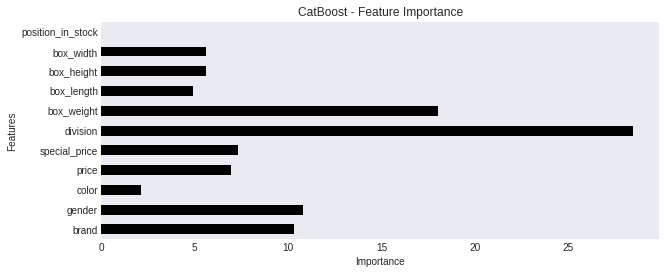

In [35]:
feat_imp = pd.DataFrame ({
    'imp': model.feature_importances_, 
    'col': X_train.columns
}) 
feat_imp.plot.barh(x='col', y='imp', figsize = (10, 4), legend=None, color='black') 
plt.title('CatBoost - Feature Importance') 
plt.ylabel('Features') 
plt.xlabel('Importance')

In [36]:
X_test = test.drop(columns=columns_to_ignore)

In [37]:
test['category'] = model.predict(X_test)
test.to_csv('dafiti_catalog_firstsolution.csv.gz', compression='gzip')
test.head()

,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,position_in_stock,category
0,Produto Sebulba Spin,Sebulba,O <Strong>Produto Sebulba Spin</Strong> É Para...,Feminino,Roxo,329.99,74.99,Sports Shoes,6.4,149.8,90.4,239.0,Setor Q,Tênis
1,Produto Bossk Dark Matrix,Bossk,<H3>Vista A Produto Bossk Dark Matrix E Deixe ...,Masculino,Verde,209.99,169.99,Sports Apparel,3.3,201.8,134.9,246.4,Setor Q,Bermuda
2,Produto Jeans Owen 2X4,Owen,<H3>A Produto Jeans Owen 2X4 Faz A Diferença N...,Masculino,Preto,194.99,154.99,Sports Apparel,3.3,224.1,45.8,127.5,Setor G,Bermuda
3,Produto Lama Su Vl 2500 Lady,Lama Su,"<H3>Produto Lama Su Vl 2500 Lady\, A Combinaçã...",Feminino,Branco,69.99,44.99,Sports Shoes,6.4,149.8,90.4,239.0,Setor E,Tênis
4,Bolsa Yoda Heritage Si Shoulder Club,Yoda,<Strong>Bolsa Yoda Heritage Si Shoulder Club</...,Feminino,Roxo,154.99,119.99,Sports Accessories,6.7,439.6,30.9,335.5,Setor E,Bagagem Pequena


### 3.2 - Model 2: Natural Language Processing

### 3.2.1 - Dataset Definition

In [38]:
columns = ['product_name', 'product_description']
X_train, y_train = train[columns], train['category']
X_valid, y_valid = valid[columns], valid['category']
X_test, y_test = test[columns], test['category']
X_train.head()

,product_name,product_description
71088,Produto Grievous Básica,"Casual\, A <B>Produto Grievous Básica</B> Vai ..."
3589,Produto Luke Skywalker Eclipsed Rasta,<H3>Visual Alternativo Para Os Pés Com O Produ...
25843,Produto C-3PO Major,"<Strong>Produto C-3PO Major</Strong>\, Modelag..."
60066,Produto R5-D4 Gotye,<H3>Garanta Um Visual Estiloso Com O Produto R...
69732,Produto Jeans R5-D4 Aloha,<H3>A Produto Jeans R5-D4 Aloha É A Tua Cara.<...


In [39]:
for i in range(20):
    print(X_train.iloc[i]['product_name'])

Produto Grievous Básica
Produto Luke Skywalker Eclipsed Rasta
Produto C-3PO Major
Produto R5-D4 Gotye
Produto Jeans R5-D4 Aloha
Produto Fisto
Sunga Luke Skywalker Dane
Produto Ki-Adi-Mundi Flux
Produto <BRAND_000013> Bill
Produto C-3PO Ozone Block B/P
Produto Crynyd Estampada 27
Produto Owen Vs6 Pixelater
Produto Mon Mothma Noble Trek
Produto <BRAND_000004> Vt 388A
Produto IG-88 Aplq 10
Blusa Greedo Team
Produto Luke Skywalker Fisher
Produto Nass Verona
Produto Luke Skywalker Cypher Hex
Produto Gunray Lockup Dri-Fit


In [40]:
for i in range(5):
    print(X_train.iloc[i]['product_description'])
    print('---------------------------')

Casual\, A <B>Produto Grievous Básica</B> Vai Deixar Suas Atividades Diárias Cheias De Conforto. Confeccionada Em Algodão\, A Peça É Leve\, Macia E Com Contato Suave À Pele. Sua Modelagem Tradicional Ajusta-Se Perfeitamente Ao Seu Corpo E Fornece Liberdade De Movimentos. Possui Bordado Frontal Com A Assinatura Da Marca E Gola Careca. Tenha Um Estilo Esportivo No Seu Dia A Dia Ou Em Passeios Casuais Com A <B>Produto Grievous Básica</B>.<Br><Br>
---------------------------
<H3>Visual Alternativo Para Os Pés Com O Produto Luke Skywalker Eclipsed Rasta.</H3>Produzido Em Material Leve\, Resistente E Durável\, O <Strong>Produto Luke Skywalker Eclipsed Rasta</Strong> Possui Tiras Que Permitem Perfeito Ajuste Aos Pés\, Garantindo Maior Bem-Estar E Pisadas Confortáveis E Macias. Seu Solado Vem Emborrachado Para Melhor Aderência Ao Solo\, Dando Estabilidade E Segurança Nas Passadas. Ideal Para Te Acompanhar Nos Dias Quentes Para Ir À Piscina Ou À Praia\, O <Strong>Produto Luke Skywalker Eclipsed

#### 3.2.2 - Text Pre-Processing Pipeline

In [41]:
sw = stopwords.words('portuguese')
sw = sw + ["da", "meu", "em", "você", "de", "ao", "os", "produto"]
stemmer = SnowballStemmer('portuguese')

def remove_html(data):
    p = re.compile(r'<.*?>')
    return p.sub(' ', str(data))

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

def stemming(text):    
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [42]:
for df in [X_train, X_valid, X_test]:
    df.product_description = df.product_description.apply(remove_html)
    df.product_description = df.product_description.fillna(' ').apply(remove_punctuation)
    df.product_description = df.product_description.fillna(' ').apply(remove_stopwords)
    df.product_description = df.product_description.fillna(' ').apply(stemming)

/home/willian.dihanster/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [43]:
for i in range(5):
    print(X_train.iloc[i]['product_description'])
    print('---------------------------')

casual grievous básic vai deix ativ diár che confort confeccion algodã pec lev mac contat suav pel modelag tradicional ajustas perfeit corp fornec liberdad moviment possu bord frontal assinatur marc gol carec estil esport dia dia passei casu grievous básic
---------------------------
visual altern pés luk skywalk eclipsed rast produz material lev resistent durável luk skywalk eclipsed rast possu tir permit perfeit ajust pés garant maior bemest pis confort mac sol vem emborrach melhor aderent sol dand estabil segur pass ideal acompanh dias quent ir piscin pra luk skywalk eclipsed rast permit adicion muit personal visual luk skywalk eclipsed rast deix pés tir onda composiçã borrach confort relev diferenc maior confort corr resistent part intern material emborrach sol resistent abrasã antiderrap estamp símbol marc
---------------------------
c3po major modelag regul composiçã 100 poliést tec ripsued listr fechament cordã 1 bols lateral aviament personaliz estamp full print nom marc detalh

#### 3.2.3 - World Cloud

In [44]:
words = X_train['product_description']
all_words = " ".join(w for w in words)

In [45]:
wordcloud = WordCloud(
    stopwords=sw,
    background_color='black', 
    width=1600,                            
    height=800
).generate(all_words)

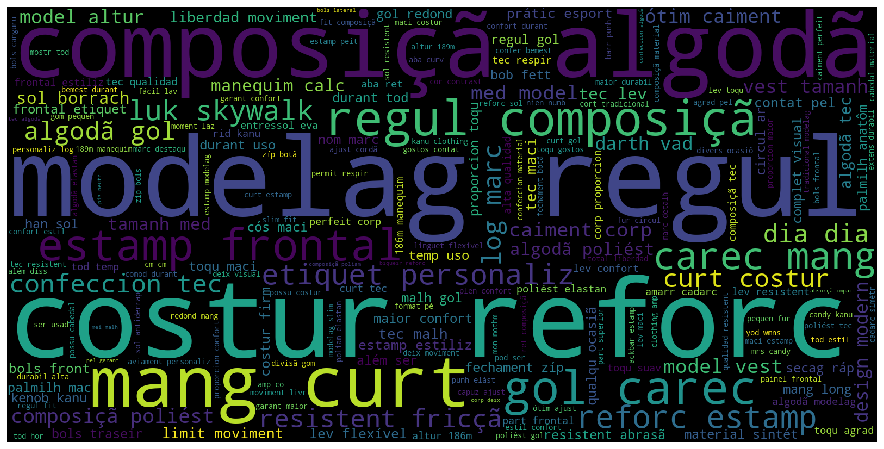

In [46]:
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)  

#### 3.2.3 - Model - TF-IDF

In [47]:
tfid_vectorizer = TfidfVectorizer('portuguese', max_features=500)
tfid_vectorizer.fit(X_train['product_description'].values.astype('U'))
dictionary = tfid_vectorizer.vocabulary_.items()  

In [48]:
tfid_matrix1 = tfid_vectorizer.transform(X_train['product_description'])
tfid_matrix2 = tfid_vectorizer.transform(X_valid['product_description'])
tfid_matrix3 = tfid_vectorizer.transform(X_test['product_description'])

In [49]:
X_train, y_train = pd.DataFrame(tfid_matrix1.todense()), train['category']
X_valid, y_valid = pd.DataFrame(tfid_matrix2.todense()), valid['category']
X_test, y_test = pd.DataFrame(tfid_matrix3.todense()), test['category']

In [50]:
X_train.columns = tfid_vectorizer.get_feature_names()
X_valid.columns = tfid_vectorizer.get_feature_names()
X_test.columns = tfid_vectorizer.get_feature_names()
X_train.head()

,100,12,186m,189m,20,40,42,43,50,aba,...,viv,warrick,watt,wav,wmns,yod,zíp,águ,ótim,únic
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.121212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.084645,0.0,0.0,0.0


In [51]:
weights = np.asarray(tfid_matrix1.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({
    'term': tfid_vectorizer.get_feature_names(), 
    'weight': weights
}).sort_values(by='weight', ascending=False)
weights_df.head(10)

,term,weight
189,estamp,0.063020
296,mang,0.059408
312,modelag,0.059037
123,composiçã,0.058061
408,regul,0.056736
29,algodã,0.055137
238,gol,0.054011
0,100,0.052868
141,costur,0.051732
144,curt,0.051066


#### 3.2.5 - Machine Learning Model

In [52]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(66791, 500)
(66791,)
(28626, 500)
(28626,)


In [53]:
model = cb.CatBoostClassifier(
    eval_metric='Accuracy', 
    random_seed=42, 
    iterations=100,
    depth=7,
    learning_rate=0.1,
)

In [54]:
model.fit(
    X_train, 
    y_train, 
    eval_set=(X_valid, y_valid), 
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [55]:
y_pred = model.predict(X_valid)

In [56]:
print(classification_report(y_valid, y_pred.flatten(), target_names=categories))

                        precision    recall  f1-score   support

              Camiseta       0.80      0.79      0.80       525
                 Tênis       0.83      0.66      0.74       296
               Bermuda       0.83      0.89      0.86      2154
                  Boné       0.70      0.49      0.57      1081
               Moletom       0.97      0.98      0.98      1869
                 Blusa       0.83      0.29      0.43       292
                 Calça       0.77      0.75      0.76       971
                  Polo       0.85      0.61      0.71       502
               Mochila       0.90      0.98      0.94     11119
                Óculos       0.96      0.89      0.92       462
                Shorts       0.98      0.63      0.77       267
Acessório de Vestuário       0.97      0.89      0.93       403
                Camisa       0.91      0.94      0.93       752
    Casacos e Jaquetas       0.91      0.92      0.92      1465
                  Meia       0.92      

In [57]:
cm = confusion_matrix(y_valid, y_pred.flatten(), labels=categories)
pd.DataFrame(cm, index=categories, columns=categories).style.background_gradient(cmap='viridis')

,Camiseta,Tênis,Bermuda,Boné,Moletom,Blusa,Calça,Polo,Mochila,Óculos,Shorts,Acessório de Vestuário,Camisa,Casacos e Jaquetas,Meia,Roupa de Banho,Bagagem Pequena,Bota,Vestido,Chinelo
Camiseta,10906,4,7,0,47,102,2,17,0,3,2,8,14,1,0,0,0,0,6,0
Tênis,1,3835,0,0,0,2,0,0,1,0,0,1,0,0,2,0,0,17,0,3
Bermuda,56,1,1915,0,1,0,157,0,0,0,9,3,2,0,2,4,4,0,0,0
Boné,11,13,5,1833,0,0,0,0,0,0,0,6,0,0,0,1,0,0,0,0
Moletom,78,0,7,0,1352,7,1,2,0,0,0,8,3,7,0,0,0,0,0,0
Blusa,473,0,1,0,33,526,3,2,0,0,1,7,10,5,0,0,0,0,20,0
Calça,16,1,196,0,3,1,733,0,3,0,0,7,1,1,0,6,0,0,3,0
Polo,209,0,0,0,0,10,0,530,0,0,0,2,20,0,0,0,0,0,0,0
Mochila,1,0,2,2,0,0,0,0,708,0,0,7,0,0,0,1,31,0,0,0
Óculos,6,7,0,0,0,0,0,0,1,661,0,9,0,0,0,1,0,0,0,0


Text(0.5, 0, 'Importance')

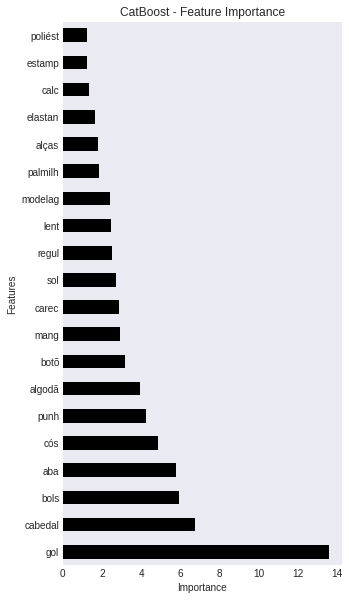

In [58]:
feat_imp = pd.DataFrame ({
    'imp': model.feature_importances_, 
    'col': X_train.columns
}).sort_values(by='imp', ascending=False)

feat_imp[0:20].plot.barh(x='col', y='imp', figsize=(5, 10), legend=None, color='black') 
plt.title('CatBoost - Feature Importance') 
plt.ylabel('Features') 
plt.xlabel('Importance')

In [59]:
test['category'] = model.predict(X_test)
test.to_csv('dafiti_catalog_nlpsolution.csv.gz', compression='gzip')
test.head()

,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,position_in_stock,category
0,Produto Sebulba Spin,Sebulba,O <Strong>Produto Sebulba Spin</Strong> É Para...,Feminino,Roxo,329.99,74.99,Sports Shoes,6.4,149.8,90.4,239.0,Setor Q,Tênis
1,Produto Bossk Dark Matrix,Bossk,<H3>Vista A Produto Bossk Dark Matrix E Deixe ...,Masculino,Verde,209.99,169.99,Sports Apparel,3.3,201.8,134.9,246.4,Setor Q,Bermuda
2,Produto Jeans Owen 2X4,Owen,<H3>A Produto Jeans Owen 2X4 Faz A Diferença N...,Masculino,Preto,194.99,154.99,Sports Apparel,3.3,224.1,45.8,127.5,Setor G,Calça
3,Produto Lama Su Vl 2500 Lady,Lama Su,"<H3>Produto Lama Su Vl 2500 Lady\, A Combinaçã...",Feminino,Branco,69.99,44.99,Sports Shoes,6.4,149.8,90.4,239.0,Setor E,Tênis
4,Bolsa Yoda Heritage Si Shoulder Club,Yoda,<Strong>Bolsa Yoda Heritage Si Shoulder Club</...,Feminino,Roxo,154.99,119.99,Sports Accessories,6.7,439.6,30.9,335.5,Setor E,Bagagem Pequena


### 3.3 - Model 3: Image Processing

In [60]:
"""

"""

'\n\n'

### 3.4 - Model 4: Models Ensemble

In [61]:
"""

"""

'\n\n'

## 4 - Conclusions